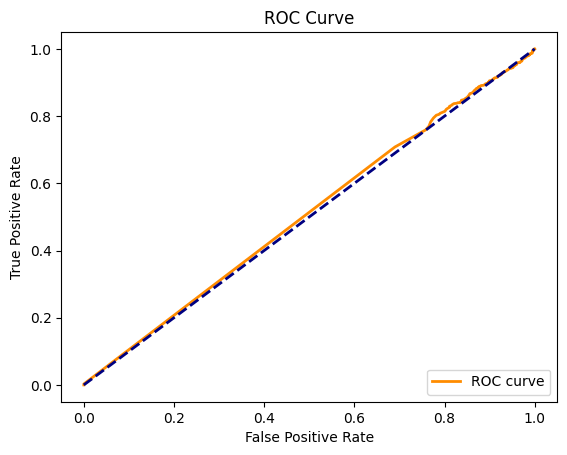

In [13]:
import torch
from sklearn.metrics import roc_curve
from sklearn.datasets import fetch_lfw_pairs
import matplotlib.pyplot as plt
import os

def load_features(filename):
    if os.path.exists(filename):
        return torch.load(filename)
    return None

def compute_cosine_similarity(features):
    cosine_similarities = []
    for feature_pair in features:
        features1, features2 = feature_pair[:512], feature_pair[512:]
        cosine_similarity = torch.nn.functional.cosine_similarity(features1.unsqueeze(0), features2.unsqueeze(0))
        cosine_similarities.append(cosine_similarity.item())
    return cosine_similarities

# Load precomputed features
train_features = load_features('train_features.pt')
test_features = load_features('test_features.pt')

# Load LFWDataset labels
lfw_pairs_train = fetch_lfw_pairs(subset='train', color=True)
X_train, y_train = lfw_pairs_train.pairs, lfw_pairs_train.target

# Compute Cosine Similarities
cosine_similarities = compute_cosine_similarity(train_features)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_train, cosine_similarities)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


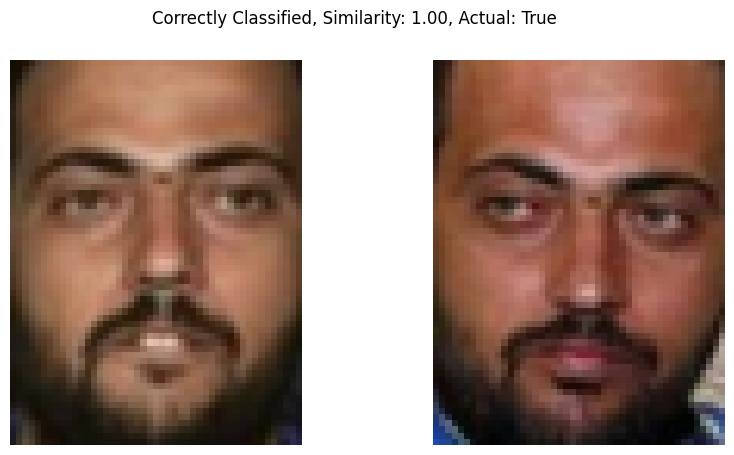

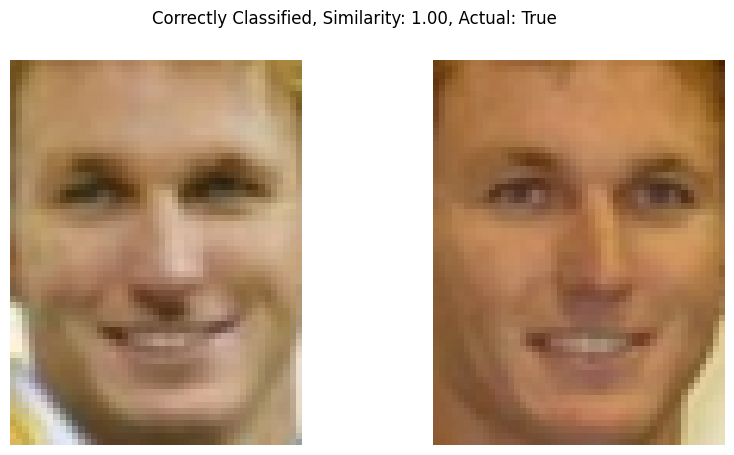

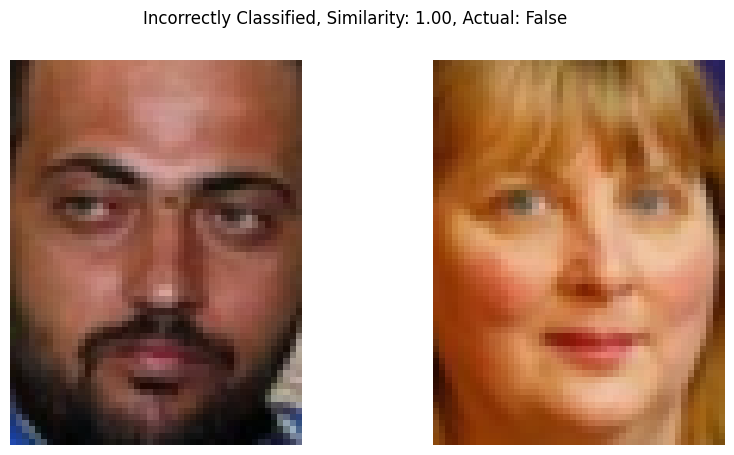

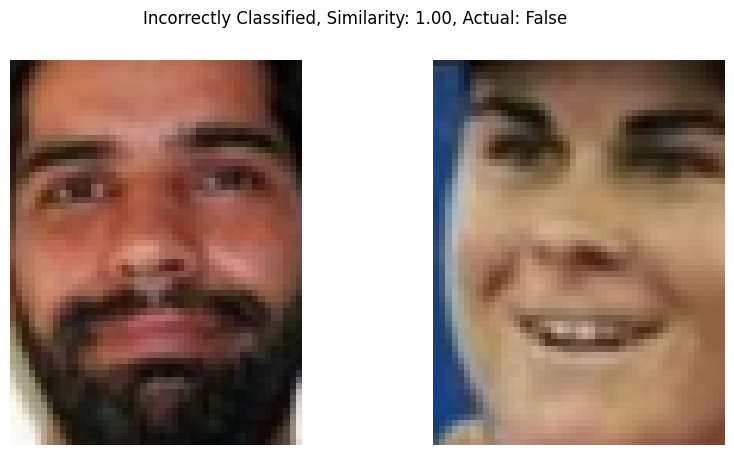

In [14]:
import matplotlib.pyplot as plt
import random

def plot_image_pair(pair, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(pair[0])
    ax[0].axis('off')
    ax[1].imshow(pair[1])
    ax[1].axis('off')
    plt.suptitle(title)
    plt.show()


# Set a threshold for classification (can be adjusted based on model performance)
threshold = 0.7  # Example threshold, adjust based on your model's performance

# Select pairs for visualization
correct_pairs = []
incorrect_pairs = []
for i, similarity in enumerate(cosine_similarities):
    predicted = similarity > threshold
    actual = y_train[i] == 1
    if predicted == actual and len(correct_pairs) < 5:
        correct_pairs.append((X_train[i], similarity, actual))
    elif predicted != actual and len(incorrect_pairs) < 5:
        incorrect_pairs.append((X_train[i], similarity, actual))

# Randomly select and plot a few correct pairs
for pair in random.sample(correct_pairs, 2):
    plot_image_pair(pair[0], f"Correctly Classified, Similarity: {pair[1]:.2f}, Actual: {pair[2]}")

# Randomly select and plot a few incorrect pairs
for pair in random.sample(incorrect_pairs, 2):
    plot_image_pair(pair[0], f"Incorrectly Classified, Similarity: {pair[1]:.2f}, Actual: {pair[2]}")


We see that the cosine similarity is close to 1.0 for all face pairs in the dataset. This indicates that CLIP is simply identifying "face", not any specific facial features. 

(array([   6.,    7.,   16.,   23.,   38.,   31.,   58.,   57.,  114.,
        1850.]),
 array([0.88574219, 0.89726562, 0.90878906, 0.9203125 , 0.93183594,
        0.94335938, 0.95488281, 0.96640625, 0.97792969, 0.98945313,
        1.00097656]),
 <BarContainer object of 10 artists>)

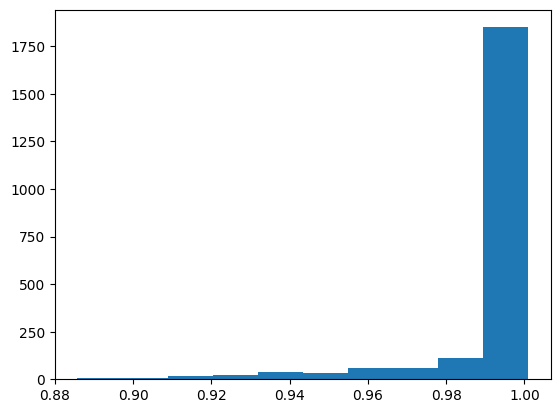

In [15]:
from matplotlib import pyplot as plt
plt.hist(cosine_similarities)

let's verify this hypothesis.

In [45]:
import clip
import torch
from sklearn.datasets import fetch_lfw_people
from PIL import Image

# Load the model and the preprocess function
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load an image from the Labeled Faces in the Wild dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
np_image = lfw_people.images[0]  # Get the first image as a NumPy array

# Convert the NumPy array to a PIL Image
pil_image = Image.fromarray(np_image.astype('uint8'), 'L')

# Preprocess the image and convert to tensor
image_tensor = preprocess(pil_image).unsqueeze(0).to(device)

# Tokenize and encode the text
text = clip.tokenize(["face"]).to(device)

# Model inference
with torch.no_grad():
    image_features = model.encode_image(image_tensor)
    text_features = model.encode_text(text)

    # Calculate the similarity (dot product) between image and text features
    similarity = (image_features @ text_features.T).softmax(dim=-1).cpu().numpy()

print("Label probs:", similarity)


Label probs: [[1.]]
